Nama   : San Antonio Limbong

NIM    : 12S19033

### Exercises

In [1]:
#pip install tensorflow-text

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
use_builtins = True

In [4]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

Kelas ini digunakan untuk memeriksa bentuk selama latihan.

### Part 1 | The data

### 1.1 Download and prepare the dataset

Berikut adalah tahapan menyiapkan data setelah melakukan download dataset:
1. Tambahkan token awal dan akhir untuk setiap kalimat.
2. Bersihkan kalimat dengan menghilangkan karakter khusus.
3. Buat indeks kata dan indeks kata terbalik (pemetaan kamus dari kata → id dan id →
kata).
4. Pada setiap kalimat dengan panjang maksimum.

In [5]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [6]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  inp = [inp for targ, inp in pairs]
  targ = [targ for targ, inp in pairs]

  return targ, inp

In [7]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [8]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


### 1.1.1 Create a tf.data dataset

Dari array string tersebut, dapat dibuat tf.data.Datasetstring yang dari array string yang melakukan pengacakan dan pengelompokan secara efisien:

In [9]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [10]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'No hago una promesa a alguien sin tom\xc3\xa1rmelo en serio.'
 b'Ya he terminado de leer este libro.' b'Me estoy quedando en Italia.'
 b'\xc2\xbfPod\xc3\xa9s llamarlo?'
 b'\xc3\x89l dice que no se privar\xc3\xa1 de fumar.'], shape=(5,), dtype=string)

tf.Tensor(
[b"I don't make a promise to someone without taking it seriously."
 b"I've already finished reading this book." b"I'm staying in Italy."
 b'Can you call him?' b"He says that he won't give up smoking."], shape=(5,), dtype=string)


### 1.2 Text preprocessing

Mengambil tf.stringinput, dan menjalankan tf.stringoutput: untuk membuat model yang diekspor berguna

#### 1.2.1 Standardization
Model yang digunakan menggunakan teks multibahasa yang terbatas sehingga perlu dilakukan standardisasi. Tahapan yang pertama dilakukan adalah melakukan normalisasi Unicode yang membagi karakter beraksen dan mengganti karakter kompatibilitas dengan ASCII yang setara.

In [11]:
example_text = tf.constant('¿Todavía está en casa?') 

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [12]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [13]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### 1.2.2 Text Vectorization
Fungsi standardisasi ini akan dibungkus dalam lapisan preprocessing.TextVectorization
yang akan menangani ekstraksi kosakata dan konversi teks input ke urutan token

In [14]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

The TextVectorizationlayer dan experimental.preprocessinglapisan lainnya memiliki adaptmetode. Satu epoch dari data pelatihan, akan dibaca oleh metode ini dan bekerja sangat mirip dengan Model.fix. Metode adapt ini menginisialisasi lapisan berdasarkan data. Di sinilah kita akan menentukan kosakata:

In [15]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

TextVectorizationlayer Spanyol telah ditampilkan pada output sebelumnya, selanjutnya build dan layer .adapt() Inggris:

In [16]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

Layer ini dapat mengubah kumpulan string menjadi kumpulan ID token:

In [17]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,    9, 1132,   23, 1343,    8,  155,  139,    1,   14],
       [   2,   89,   74,  571,    6,  266,   40,  105,    4,    3],
       [   2,   18,   41, 2258,   14, 1469,    4,    3,    0,    0]],
      dtype=int64)>

Method get_vocabulary digunakan untuk mengkonversi ID tanda kembali ke teks:

In [18]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] no hago una promesa a alguien sin [UNK] en serio . [END]                            '

ID token yang dikembalikan tidak diisi. Ini dapat dengan mudah diubah menjadi mask:

Text(0.5, 1.0, 'Mask')

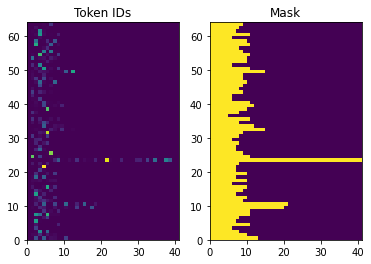

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### Part 2 | The encoder/decoder model
Diagram berikut menunjukkan gambaran umum model. Pada setiap langkah waktu, output dekoder digabungkan dengan jumlah bobot di atas input yang dikodekan, untuk memprediksi kata berikutnya.
![title](images.jpg)
Sebelum masuk ke dalamnya, kita harus menentukan beberapa konstanta untuk model terlebih dahulu

In [20]:
embedding_dim = 256
units = 1024

#### 2.1 The encoder
Bagian biru dari diagram di atas adalah encoder.Encoder :
1.   Mengambil daftar ID token (dari input_text_processor).
2.   Mencari vektor penyematan untuk setiap token (Menggunakan a layers.Embedding).
3.   Memproses embeddings menjadi urutan baru (Menggunakan sebuah layers.GRU).
4.   Returns:
      * Urutan yang diproses. 
      * Keadaan internal. 

In [21]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [22]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 41)
Encoder output, shape (batch, s, units): (64, 41, 1024)
Encoder state, shape (batch, units): (64, 1024)


Encoder mengembalikan state internalnya sehingga statenya dapat digunakan untuk menginisialisasi decoder.
RNN juga umum untuk mengembalikan statenya sehingga dapat memproses urutan melalui beberapa panggilan. 

### 2.2 The attention head
Decoder menggunakan attention untuk selektif fokus pada bagian dari urutan input. Lapisan attention ini mirip dengan sebuah layers.GlobalAveragePoling1D tetapi lapisan attention melakukan rata-rata tertimbang. Kelas di bawah ini menangani matriks bobot dalam sepasang layers.Denselapisan, dan memanggil implementasi bawaan.

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### 2.3 Test the Attention layer
Create a BahdanauAttention layer:

In [24]:
attention_layer = BahdanauAttention(units)

Lapisan ini membutuhkan 3 input:
*   **query**: Akan dihasilkan oleh decoder, nanti.
*   **value**: Akan menjadi output dari encoder.
*   **mask:** Untuk mengecualikan padding,example_tokens != 0

In [25]:
(example_tokens != 0).shape

TensorShape([64, 41])

Implementasi vektor dari lapisan perhatian memungkinkan untuk melintasi rangkaian vektor kueri dan rangkaian vektor nilai dan hasilnya adalah:
*   Kumpulan urutan vektor hasil ukuran kueri.
*   Sebuah batch attention maps, dengan ukuran (query_length, value_length).

In [26]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 41)


Bobot attention harus dijumlahkan 1.0untuk setiap urutan.

Berikut adalah bobot attention di seluruh urutan di t=0:

Text(0.5, 1.0, 'Mask')

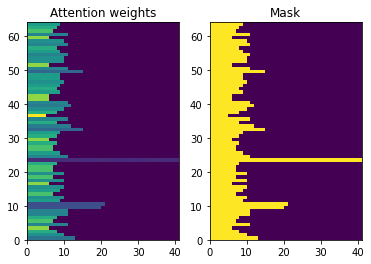

In [27]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

Bobot attention semuanya mendekati 1/(sequence_length), karena inisialisasi acaknya kecil. Apabila bobot untuk satu urutan diperbesar, maka beberapa variasi kecil yang dapat dipelajari dan dikembangkan oleh model untuk dikembangkan bisa dilihat.

In [28]:
attention_weights.shape

TensorShape([64, 2, 41])

In [29]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

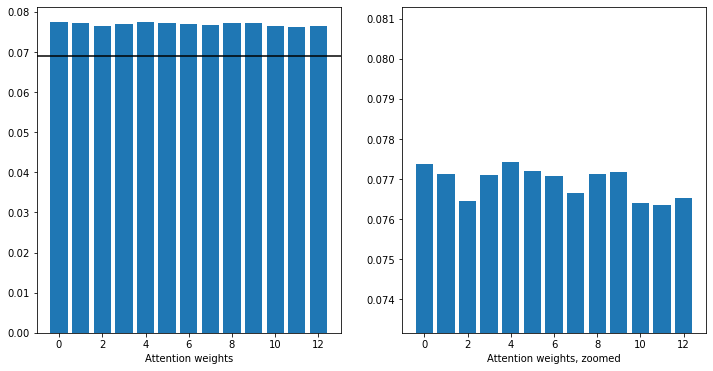

In [30]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

Tugas dekoder adalah menghasilkan prediksi untuk token keluaran berikutnya.

1.   Decoder menerima output encoder lengkap.
2.   Menggunakan RNN untuk melacak apa yang telah dihasilkan sejauh ini.
3.  Menggunakan output RNN sebagai permintaan untuk memperhatikan output encoder, menghasilkan vektor konteks.
4.   Menggabungkan output RNN dan vektor konteks menggunakan Persamaan 3 (di bawah) untuk menghasilkan "vektor attention".
5.   Menghasilkan prediksi logit untuk token berikutnya berdasarkan "vektor attention".

Berikut Decoderkelas dan penginisialisasinya dimana penginisialisasi akan membuat semua lapisan yang diperlukan.

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

Metode call untuk lapisan ini mengambil dan mengembalikan beberapa tensor.

In [32]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Berikut implementasi dari callmetodenya.

In [33]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [34]:
Decoder.call = call

Encoder memproses urutan input penuh dengan satu panggilan ke nya RNN.

In [35]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

Decoder membutuhkan 4 input, yakni:

*   new_tokens- Token terakhir yang dihasilkan. Inisialisasi dekoder dengan "[START]"token.
*   enc_output- Dihasilkan oleh Encoder.
*   mask - Tensor boolean yang menunjukkan di mana tokens != 0
*   state- stateOutput sebelumnya dari dekoder (keadaan internal RNN dekoder).


In [36]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [37]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [38]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode token sebagai kata pertama dari output:

In [39]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['anticipated'],
       ['closing'],
       ['unemployed'],
       ['plate'],
       ['ham']], dtype='<U16')

Menggunakan dekoder untuk menghasilkan set log kedua.

In [40]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [41]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['climbed'],
       ['argue'],
       ['pleasant'],
       ['aimed'],
       ['england']], dtype='<U16')

### Part 3 | Training
untuk melatih sebuah model, dibutuhkan:
*   sebuah loss function dan pengoptimalan
*   fungsi training step
*   Training loop untuk mendorng pelatihan dan menyimpan pos pemeriksaan.

### 3.1 Define the loss function

In [42]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### 3.2 Implement the training step
Melalui model ini, train_step akan diimplementasikan dari proses training dimana train_stepmetodenya sebagai pembungkus di area _train_step.

In [43]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Metode _preprocess ditambahkan di bawah

In [44]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [45]:
TrainTranslator._preprocess = _preprocess

Metode _train_step, menambahkan bawah, menangani langkah-langkah yang tersisa

In [46]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [47]:
TrainTranslator._train_step = _train_step

Metode _loop_step, ditambahkan di bawah, mengeksekusi decoder dan menghitung kerugian tambahan dan negara decoder baru ( dec_state).

In [48]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [49]:
TrainTranslator._loop_step = _loop_step

### 3.3 Test the training step
Membangun TrainTranslator, dan mengkonfigurasikan untuk pelatihan menggunakan metode Model.compile:

In [50]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Melakukan uji coba train_step

In [51]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [52]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6669874>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.636483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.578922>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.405642>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.6218333>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4092264>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.590914>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3783317>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3038282>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2555594>}

CPU times: total: 7min 36s
Wall time: 1min 35s


_train_step metode bekerja, bisa mencoba tf.function -wrapped _tf_train_step , untuk memaksimalkan kinerja sambil pelatihan:

In [53]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [54]:
TrainTranslator._tf_train_step = _tf_train_step

In [55]:
translator.use_tf_function = True

Panggilan pertama untuk melacak fungsi

In [56]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.976188>}

Untuk melihat bahwa model tersebut dapat memenuhi satu batch input, maka diperlukan tes yang baik

In [57]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2055726>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.107156>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.970237>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8977084>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.885584>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.858694>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8648908>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8521886>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8003402>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7605438>}

CPU times: total: 8min 41s
Wall time: 1min 10s


....................................................................................................


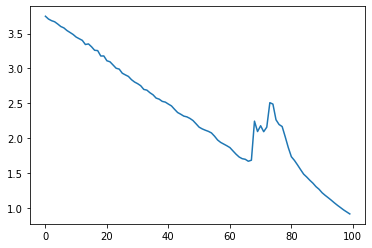

In [58]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Salinan model baru untuk dilatih dari awal akan dibuat, karena berdasarkan hasil diatas, bisa kita lihat bahwa langkah pelatihan yang dilakukan berhasil.

In [59]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### 3.4 Train the model

Disini, Callback akan digunakan untuk mengumpulkan history batch loss.

In [60]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss') 

In [ ]:
train_translator.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

### Part 4 | Translate
Sekarang setelah model dilatih, implementasikan fungsi untuk mengeksekusi teks lengkap => terjemahan teks.
Untuk ini model perlu membalikkan teks => pemetaan ID token yang disediakan oleh
output_text_processor. Itu juga perlu mengetahui ID untuk token khusus. Ini semua dilaksanakan
di konstruktor untuk kelas baru. Implementasi metode terjemahan yang sebenarnya akan mengikuti

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### 4.1 Convert token IDs to text
Metode pertama yang diterapkan adalah tokens_to_text yang mengubah dari ID token menjadi dapat dibaca manusia
teks.

In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

Masukkan beberapa ID token acak dan lihat apa yang dihasilkannya:

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

### 4.2 Sample from the decoder's predictions
Fungsi ini mengambil keluaran logit dekoder dan mengambil sampel ID token dari distribusi tersebut:

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

Uji coba fungsi ini pada beberapa input acak:

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

### 4.3 Implement the translation loop
Implementasi dari loop terjemahan teks ke teks secara lengkap. Sebelum menggunakan tf.concat, hasil dari daftar python dikumpulkan untuk digabungkan dalam tensorflow.

In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

Jalankan pada sample input :

In [ ]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

Jika Anda ingin mengekspor model ini, Anda harus membungkus metode ini dalam tf.function. Dasar ini
implementasi memiliki beberapa masalah jika Anda mencoba melakukannya:
1. Grafik yang dihasilkan sangat besar dan membutuhkan beberapa detik untuk dibuat, disimpan, atau dimuat.
2. Anda tidak dapat memutuskan dari loop yang dibuka secara statis, sehingga iterasi akan selalu berjalan max_length, bahkan jika semua output dilakukan. Tapi meski begitu, itu sedikit lebih cepat daripada eksekusi yang bersemangat

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run tf.function once to compile it:

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  shape_checker = ShapeChecker()
  shape_checker(input_text, ('batch',))

  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
  shape_checker(input_tokens, ('batch', 's'))

  enc_output, enc_state = self.encoder(input_tokens)
  shape_checker(enc_output, ('batch', 's', 'enc_units'))
  shape_checker(enc_state, ('batch', 'enc_units'))

  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)
  shape_checker(new_tokens, ('batch', 't1'))

  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  shape_checker(done, ('batch', 't1'))

  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)
    shape_checker(dec_result.logits, ('batch', 't1', 'vocab'))
    shape_checker(new_tokens, ('batch', 't1'))

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()
  shape_checker(result_tokens, ('t', 'batch', 't0'))
  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
  shape_checker(result_tokens, ('batch', 't'))

  result_text = self.tokens_to_text(result_tokens)
  shape_checker(result_text, ('batch',))

  if return_attention:
    attention_stack = attention.stack()
    shape_checker(attention_stack, ('t', 'batch', 't1', 's'))

    attention_stack = tf.squeeze(attention_stack, 2)
    shape_checker(attention_stack, ('t', 'batch', 's'))

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    shape_checker(attention_stack, ('batch', 't', 's'))

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_symbolic

tf.range digunakan sebagai loop iterator, yang mana tf.autoraph dimungkinkan untuk mengkonversi loop. Sedangkan tf.Tensorarray digunakan untuk mengumpulkan sejumlah variabel tensor dalam mode grafik.

In [ ]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

Pembuatan grafik jauh lebih cepat, karena tidak mencipatakan max_iterations salinan model. Kemudian fungsi yang dikompilasi jauh lebih cepat karena dapat keluar dari loop

### 4.4 Visualize the process
Bobot perhatian yang dikembalikan oleh metode terjemahan menunjukkan di mana model itu "looking" ketika
itu menghasilkan setiap token keluaran.
Jadi jumlah perhatian atas input harus mengembalikan semuanya:

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

Berikut distribusi attention untuk langkah keluaran pertama dari contoh pertama.

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

Bagian attention jauh lebih terfokus dari pada untuk model yang tidak terlatih. Namun, karena terdapat beberapa keselarasan kasar antara kata-kata input dan output, attentio diharapkan bisa difokuskan di dekat diagonal.

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

untuk membuat plot attention yang lebih baik, digunakan kode berikut:

In [ ]:
#@title Labeled attention plots
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

Untuk menerjemahkan beberapa kalimat lagi dan membuat plotnya.

In [ ]:
%%time
three_input_text = tf.constant([
    # This is my life.
    'Esta es mi vida.',
    # Are they still home?
    '¿Todavía están en casa?',
    # Try to find out.'
    'Tratar de descubrir.',
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

In [ ]:
result['text']

In [ ]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [ ]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

In [ ]:
result = translator.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

### Part 5 | Export
Setelah memiliki model yang diinginkan, ada kalanya ingin mengekspornya untuk digunakan di luar program python yang membuatnya sebagai tf.saved_model. Oleh karena itu, bisa diekspor menggunakan saved_model.save.

In [ ]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

### Exploration
* Unduh kumpulan data yang berbeda untuk bereksperimen dengan terjemahan, misalnya, Bahasa Inggris ke Bahasa Jerman, atau Bahasa Inggris ke Bahasa Prancis.
* Bereksperimen dengan pelatihan pada kumpulan data yang lebih besar, atau menggunakan lebih banyak epochs.